In [39]:
import torch
import torchvision
from torch import nn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
from torchvision import transforms
import pickle
import torch.nn.functional as F

## dati

In [8]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [9]:
class AutoEncodeDataset(Dataset):
    """"""

    def __init__(self, dataset_gt, dataset_blur):
        self.dataset_gt = dataset_gt
        self.dataset_blur = dataset_blur

    def __len__(self):
        return len(self.dataset_gt)

    def __getitem__(self, idx):
        x, _ = self.dataset_blur.__getitem__(idx)
        y, _ = self.dataset_gt.__getitem__(idx)
        return x, y

In [10]:
initial_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(112),
    transforms.Normalize(0.5,0.5)])

blur_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(112),
    transforms.GaussianBlur(9,4),
    transforms.Normalize(0.5,0.5)])

In [11]:
data_dir = 'lfw_torch/'

train_dataset = AutoEncodeDataset(
    torchvision.datasets.LFWPeople(data_dir, split='train', download=True, transform=initial_transform),
    torchvision.datasets.LFWPeople(data_dir, split='train', download=True, transform=blur_transform)
)

test_dataset = AutoEncodeDataset(
    torchvision.datasets.LFWPeople(data_dir, split='test', download=True, transform=initial_transform),
    torchvision.datasets.LFWPeople(data_dir, split='test', download=True, transform=blur_transform)
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
batch_size = 8

N_val = int(len(train_dataset)*0.2)
train_dataset_red, val_dataset = random_split(train_dataset, 
                                 lengths=[len(train_dataset)-N_val, N_val], 
                                 generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,)
train_dataloader_red = DataLoader(train_dataset_red, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [13]:
def plotrescale(data):
    return np.dstack(data)*0.5 + 0.5

## perc loss

In [54]:
vgg = torchvision.models.vgg16(pretrained = True) # c'è anche vgg16_bn con la batch normaliz

In [15]:
vgg.features # voglio 5, 6, ..., 15. Il 4 è il maxpool che scende a 112*112, il 16 a 28*28

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [16]:
f = vgg.features[5:16]
f

Sequential(
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
)

In [35]:
t = test_dataset[0][0].unsqueeze(0)
f(t).shape

RuntimeError: Given groups=1, weight of size [128, 64, 3, 3], expected input[1, 3, 112, 112] to have 64 channels, but got 3 channels instead

In [28]:
def plot_img(x):
    y = x.cpu().numpy() * 0.5 + 0.5 # normaliz
    if y.shape != torch.Size([3, 112, 112]):
        y = y.squeeze(0)
    y = y.transpose([1, 2, 0])
    # print(y.shape)
    plt.imshow(y)

(112, 112, 3)


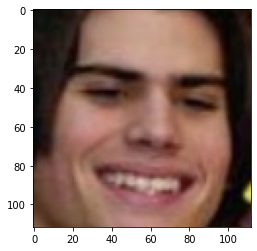

In [30]:
t = test_dataset[0][1].unsqueeze(0)
plot_img(t)

In [31]:
def plot_img_hd(x):
    y = x.cpu().numpy() * 0.5 + 0.5 # normaliz
    if y.shape != torch.Size([3, 224, 224]):
        y = y.squeeze(0)
    y = y.transpose([1, 2, 0])
    # print(y.shape)
    plt.imshow(y)

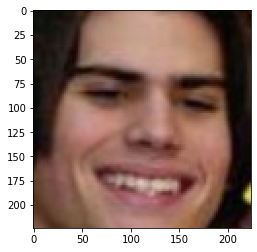

In [33]:
up = nn.Upsample(size = (224, 224)) # oppure scale_factor = 2 (112*2=224)
plot_img_hd(up(t)) # https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html

In [36]:
f = vgg.features[:16]
f

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
)

In [38]:
f(up(t)).shape

torch.Size([1, 256, 56, 56])

In [55]:
# for param in vgg.features.parameters(): # https://stackoverflow.com/questions/51748138/pytorch-how-to-set-requires-grad-false
#     param.requires_grad = False
vgg.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [79]:
up = nn.Upsample(scale_factor = 2)
f = vgg.features[:16].to(device)

def perc_loss(x1, x2): # le 2 immagini o i 2 batch (non cambia, fa la mse di due tensori, indipendentemente da 1 o batch_size come prima dim.)
    # inoltre anche Upsample si aspetta che le prime due dim. siano numero e canale, tocca solo le ultime 2 (cfr docs)
    return F.mse_loss(f(up(x1)), f(up(x2))) # versioni hd -> vgg16 -> mse

In [57]:
t0, t1 = test_dataset[0]
t0 = t0.unsqueeze(0)
t1 = t1.unsqueeze(0)
perc_loss(t0, t1)

tensor(1.5963, grad_fn=<MseLossBackward0>)

In [58]:
l = perc_loss(t0, t1)
l.backward()

In [42]:
t.shape

torch.Size([1, 3, 112, 112])

In [41]:
F.mse_loss(t, t)

tensor(0.)

## CAE

In [60]:
class ConvAutoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ## Encoder
        # N, 3, 112, 112
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 9), # N, 16, 104, 104
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2, padding=1), # N, 32, 51, 52
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # N, 32, 26
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2), # N, 32, 12
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        ## Decoder
        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, stride=2), # N, 32, 10, 10
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # N, 16, 28, 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # N, 16, 56, 56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 9),
            nn.Tanh()  
        )

    #     self.avg = nn.Sequential(
    #         nn.ConvTranspose2d(256, 256, 1),
    #         nn.BatchNorm2d(256),
    #         #nn.ReLU(),
    #     )

    #     self.log_var = nn.Sequential(
    #         nn.ConvTranspose2d(256, 256, 1),
    #         nn.BatchNorm2d(256),
    #         #nn.ReLU(),
    #     )
        
    # def sample_in_latent_space(self, mu, log_var): # sampling from MVN in latent space with provided mean and variances
    #     sigma = torch.exp(0.5 * log_var) #log_var is log(variance) = log(sigma**2) = 2 * log(sigma)
    #     return mu + torch.randn_like(mu) * sigma
    #     #Var(aX) = a**2 Var(X), so we need to multiply pred_sqrt_var = sigma (square root of the variance) by the standard normal distribution

    def forward(self, x):
        x = self.encoder(x)
        # avg = self.avg(x)
        # log_var = self.log_var(x)
        # x = self.sample_in_latent_space(avg, log_var)
        x = self.decoder(x)
        return x#, avg, log_var
    
### Training cycle function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    foo = tqdm(dataloader)
    for image_batch, label_batch in foo: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        # Encode-Decode data
        decoded_data = model(image_batch)
        ##
        #latent_img = model.encoder(image_batch)
        #latent_lab = model.encoder(label_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, label_batch) #+ loss_fn(latent_img, latent_lab)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        foo.set_description('Train batch loss: %f' % (loss.data))

### Testing cycle function
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        val_loss = []
        for image_batch, label_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Encode-Decode data
            decoded_data = model(image_batch)
            ##
            #latent_img = model.encoder(image_batch)
            #latent_lab = model.encoder(label_batch)
            # Batch loss
            loss_batch = loss_fn(decoded_data, label_batch) #+ loss_fn(latent_img, latent_lab)
            # Append the loss
            val_loss.append(loss_batch.detach().cpu().numpy())
    return np.mean(val_loss)

### Trainer
def run_training(model, num_epochs, train_dataloader, val_dataloader, optim, loss_fn, device):
    model.to(device)
    val_loss_log = []
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training
        train_epoch(
            model=model,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            model=model,
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
        val_loss_log.append(val_loss)
        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        lab = test_dataset[0][1].unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            rec_img  = model(img)
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 3, figsize=(9,3))
        axs[0].imshow(plotrescale(lab.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(plotrescale(img.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[1].set_title('Blurred image')
        axs[2].imshow(plotrescale(rec_img.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[2].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        plt.show()
        plt.close()

        # Save network parameters
        #torch.save(model.state_dict(), 'CAE/state_dict'+str(epoch)+'.pth')

    with open('CAE_validation_loss', 'wb') as fp:
        pickle.dump(val_loss_log, fp)

    return  val_loss_log

In [80]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
ConvAut = ConvAutoencoder()

### Define the loss function
loss_fn = perc_loss #torch.nn.MSELoss()

### Define an optimizer 
params_to_optimize = [
    {'params': ConvAut.encoder.parameters()},
    {'params': ConvAut.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=5e-4, weight_decay=1e-5)

In [82]:
# CAE_loss = run_training(ConvAut, 15, train_dataloader, test_dataloader, optim, loss_fn, device)

In [87]:
list(f[0].parameters())

[Parameter containing:
 tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
           [-5.8312e-01,  3.5655e-01,  7.6566e-01],
           [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
 
          [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
           [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
           [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
 
          [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
           [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
           [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
 
 
         [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
           [-4.2805e-01, -2.4349e-01,  2.4628e-01],
           [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
 
          [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
           [-8.4127e-01, -3.5176e-01,  5.6398e-01],
           [-2.4194e-01,  5.1928e-01,  5.3915e-01]],
 
          [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
           [-4.7144e-01, -1.5503e-01,  3.4589e-01],
           [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],
 
 
         [[[ 1.77

In [90]:
g = torchvision.models.vgg16(pretrained = True).features[:16]
list(g[0].parameters())

[Parameter containing:
 tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
           [-5.8312e-01,  3.5655e-01,  7.6566e-01],
           [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
 
          [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
           [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
           [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
 
          [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
           [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
           [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
 
 
         [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
           [-4.2805e-01, -2.4349e-01,  2.4628e-01],
           [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
 
          [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
           [-8.4127e-01, -3.5176e-01,  5.6398e-01],
           [-2.4194e-01,  5.1928e-01,  5.3915e-01]],
 
          [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
           [-4.7144e-01, -1.5503e-01,  3.4589e-01],
           [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],
 
 
         [[[ 1.77

## V CAE

In [ ]:
class VConvAutoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ## Encoder
        # N, 3, 112, 112
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 9), # N, 16, 104, 104
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2, padding=1), # N, 32, 51, 52
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # N, 32, 26
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2), # N, 32, 12
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        ## Decoder
        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, stride=2), # N, 32, 10, 10
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # N, 16, 28, 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # N, 16, 56, 56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 9),
            nn.Tanh()  
        )

        self.avg = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 1),
            nn.BatchNorm2d(256),
            #nn.ReLU(),
        )

        self.log_var = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 1),
            nn.BatchNorm2d(256),
            #nn.ReLU(),
        )
        
    def sample_in_latent_space(self, mu, log_var): # sampling from MVN in latent space with provided mean and variances
        sigma = torch.exp(0.5 * log_var) #log_var is log(variance) = log(sigma**2) = 2 * log(sigma)
        return mu + torch.randn_like(mu) * sigma
        #Var(aX) = a**2 Var(X), so we need to multiply pred_sqrt_var = sigma (square root of the variance) by the standard normal distribution

    def forward(self, x):
        x = self.encoder(x)
        avg = self.avg(x)
        log_var = self.log_var(x)
        x = self.sample_in_latent_space(avg, log_var)
        x = self.decoder(x)
        return x#, avg, log_var
    
### Training cycle function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    foo = tqdm(dataloader)
    for image_batch, label_batch in foo: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        # Encode-Decode data
        decoded_data = model(image_batch)
        ##
        #latent_img = model.encoder(image_batch)
        #latent_lab = model.encoder(label_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, label_batch) #+ loss_fn(latent_img, latent_lab)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        foo.set_description('Train batch loss: %f' % (loss.data))

### Testing cycle function
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        val_loss = []
        for image_batch, label_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Encode-Decode data
            decoded_data = model(image_batch)
            ##
            #latent_img = model.encoder(image_batch)
            #latent_lab = model.encoder(label_batch)
            # Batch loss
            loss_batch = loss_fn(decoded_data, label_batch) #+ loss_fn(latent_img, latent_lab)
            # Append the loss
            val_loss.append(loss_batch.detach().cpu().numpy())
    return np.mean(val_loss)

### Trainer
def run_training(model, num_epochs, train_dataloader, val_dataloader, optim, loss_fn, device):
    model.to(device)
    val_loss_log = []
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training
        train_epoch(
            model=model,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            model=model,
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
        val_loss_log.append(val_loss)
        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        lab = test_dataset[0][1].unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            rec_img  = model(img)
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 3, figsize=(9,3))
        axs[0].imshow(plotrescale(lab.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(plotrescale(img.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[1].set_title('Blurred image')
        axs[2].imshow(plotrescale(rec_img.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[2].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        plt.show()
        plt.close()

        # Save network parameters
        #torch.save(model.state_dict(), 'VCAE/state_dict'+str(epoch)+'.pth')

    with open('CAE_validation_loss', 'wb') as fp:
        pickle.dump(val_loss_log, fp)

    return  val_loss_log

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
VConvAut = VConvAutoencoder()

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer 
params_to_optimize = [
    {'params': VConvAut.encoder.parameters()},
    {'params': VConvAut.decoder.parameters()},
    {'params': VConvAut.avg.parameters()},
    {'params': VConvAut.log_var.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=5e-4, weight_decay=1e-5)

In [ ]:
VCAE_loss = run_training(VConvAut, 15, train_dataloader, test_dataloader, optim, loss_fn, device)